In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda as cuda
from torch.utils.data import DataLoader
import os
import time
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchinfo import summary
#import timm # Unofficial pytorch image models, for comparison
from PIL import Image
from pathlib import Path
%matplotlib inline

from torchvision import datasets, models, transforms

1. GPU or No GPU that is the question?
   - Check to see if your computer is cuda compatible 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use Nvidia GPU if available, for faster results

2. 

In [4]:
# Define the transformations that will be applied to the images during the loading process
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Mean and Std. Dev values used here are commonly used with the ImageNet dataset
])

In [5]:
# Training Settings
batch_size = 32 # This should usually be kept to a size that is a power of two
epochs = 15 # Need to monitor validation loss during training to avoid overfitting https://datascience.stackexchange.com/questions/46523/is-a-large-number-of-epochs-good-or-bad-idea-in-cnn
lr = 3e-5 # Need to implement learning rate decay 
gamma = 0.7
seed = 2147483647
# We'll use a PyTorch Generator to make things repeatable (deterministic)
g = torch.Generator().manual_seed(seed)

In [6]:
# Define path to dataset
dataset_path = r""

# Load Datasets with labels
dset = datasets.ImageFolder(dataset_path, transform=transform) # Automatially assigns labels to examples based on the directory name

# Generate 2 splits: Train (80%), Test (20%)
dset_size = len(dset)
train_size = int(0.8 * dset_size)
test_size = dset_size - train_size

train, test = torch.utils.data.random_split(dset, [train_size, test_size], generator=g)

# Create Data Loaders fro splits
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test, batch_size=batch_size, shuffle=True)

FileNotFoundError: [WinError 3] The system cannot find the path specified: "C:\\Users\\Brand\\Documents\\Branden's Stuff\\Python\\BusyBee\\data\\images"

In [7]:
classes = len(dset.classes)
classes

NameError: name 'dset' is not defined

In [8]:
# Training Statistics Init
train_loss_dict = {}
test_loss_dict = {}
time_to_train_dict = {}
test_accuracy_dict = {}

def train_model(model, name: str) -> None:
    """ trains the model while implementing cross validation setup

    Args:
        model (_type_): _description_
        name (_type_): _description_

    Returns:
        _type_: _description_
    """

    
    # Loss Function
    criterion = nn.CrossEntropyLoss() # creates the loss function
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr) # optimization function
    # Scheduler
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma) # Learning rate decay function
    print("")
    print(f"               [Model: {name}]")

    # Training Statistics Init
    train_loss_list = []
    test_loss_list = []
    test_accuracy_list = []
    
    
    # Training Time
    start_event = cuda.Event(enable_timing=True)
    end_event = cuda.Event(enable_timing=True)
    # Begin Clock
    start_event.record()
    
    # Training Loop
    for epoch in range(epochs):
        epoch_loss = 0

        # print("Training: ")
        model.train()
        for data, label in tqdm(train_dl):
            
            data = data.to(device) # Ensure we're processing data on GPU
            label = label.to(device)
        
            output = model(data)
            loss = criterion(output, label)
        
            optimizer.zero_grad() # Zero out the gradient -- we'll experience weird bugs if we forget to do so
            loss.backward()
            optimizer.step()
        
            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_loss += loss / len(train_dl)
        
        model.eval()
        test_accuracy, test_loss = 0,0
        # print("Testing: ")
        
        with torch.inference_mode():
            for data, label in test_dl:
                data = data.to(device)
                label = label.to(device)
                
                output = model(data)

                loss += criterion(output, label)
                acc = (output.argmax(dim=1) == label).float().mean().cpu().detach().numpy()
                test_accuracy += acc / len(test_dl)
                test_loss = loss / len(test_dl)

        print(f"Epoch: {epoch+1} - train loss: {epoch_loss:.4f} - test loss: {test_loss:.4f} - test acc: {test_accuracy:.4f}")
        train_loss_list.append(epoch_loss.cpu().detach().numpy().item())
        test_loss_list.append(test_loss.cpu().detach().numpy().item())
        test_accuracy_list.append(test_accuracy)

    end_event.record()
    cuda.synchronize() # Wait for GPU operations to complete
    time = start_event.elapsed_time(end_event) / 1000 # Convert to seconds
    num_examples = batch_size * len(train_dl)
    time_per_example = time / (num_examples * epochs)
    print(f"It took {time} seconds to train {name} on {num_examples} examples over {epochs} epochs.")
    print(f"That averages to {time_per_example} seconds per example")
    
    train_loss_dict = ({"Train Loss": train_loss_list})
    test_loss_dict = ({"Test Loss": test_loss_list})
    time_to_train_dict = ({name: time_per_example})
    test_accuracy_dict = ({"Test Accuracy": test_accuracy_list})
    return train_loss_dict, test_loss_dict, test_accuracy_dict

In [11]:
# ResNet - 18
res_net_18_weights = models.ResNet18_Weights.DEFAULT
res_net_18 = models.resnet18(weights=res_net_18_weights).to(device)
num_ftrs = res_net_18.fc.in_features

summary(model=res_net_18, 
              input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
              col_names=["input_size", "output_size", "num_params", "trainable"],
              col_width=20,
              row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

In [16]:
for param in res_net_18.parameters():
    param.requires_grad = False

for param in res_net_18.fc.parameters():
    param.requires_grad = True

res_net_18.fc = nn.Sequential(
    nn.Linear(num_ftrs, 23)
)

summary(model=res_net_18, 
              input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
              col_names=["input_size", "output_size", "num_params", "trainable"],
              col_width=20,
              row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 23]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [90]:
def save(model_name, model):
    MODEL_PATH = Path("models")
    
    if not os.path.exists("models"):
        MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    else:
        MODEL_SAVE_PATH = MODEL_PATH / f"{model_name}.pth"
        torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

def load(model_name, model):
    pass

C:\Users\Brand\AppData\Local\Temp\ipykernel_26944\371499593.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


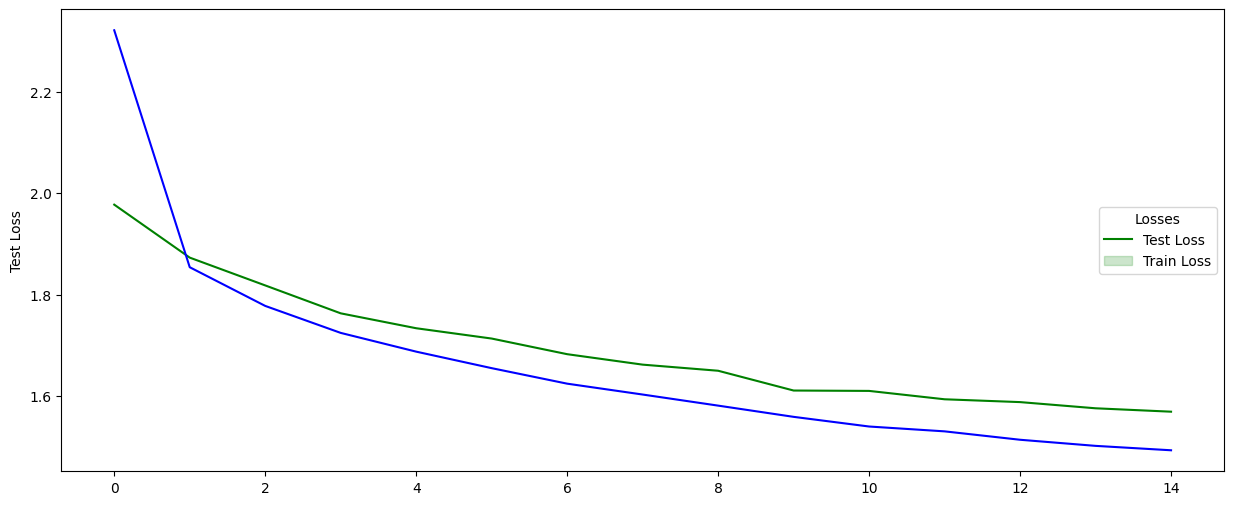

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

resnet_df = pd.concat([pd.DataFrame(train_loss), pd.DataFrame(test_loss), pd.DataFrame(test_acc)], axis=1)
resnet_df.to_csv(r"C:\Users\Brand\project_env\models\resnet18\resnet_metric.csv")


plt.figure(figsize=(15,6))
test_loss_graph = sns.lineplot(data=resnet_df["Test Loss"], color = "green")
train_loss_graph = sns.lineplot(data=resnet_df["Train Loss"], color = "blue")

# plt.xlabel("Loss")
plt.legend(title='Losses', loc='right', labels=['Test Loss', 'Train Loss'])
# test_loss_graph
plt.show()

Folder Structure,

**Models**
1. VIT
   1. Model Name
      - BusyBee Model Parameters ( **state_dict()** )
      - Model Stats ( **csv file** )

2. CNN
   1. Model Name
      - Model Parameters ( **state_dict()** )
      - Model Stats ( **csv file** )
      
Example
***




> res18 = BusyBee("resnet18")
> res18.summary()
> res18.metrics()
> BusyBee.add(model)



Create a dictionary with all of the train models save path, and model_type:

    Example 
    -------

    self.default_models = {resnet18: models.resnet18(weights=models.ResNet18)}

    self.models = { resnet18: (model/resnet18, models.resnet18(weights=models.ResNet18)),
                        resnet50: model/resnet50, models.resnet50(weights=models.ResNet50)
                        alexnet: model/alexnet,
                        lenet: model/lenet,
                        vgg16: model/vgg16,
                        vgg19: model/vgg19
                  }
        
    ^ Should be a static variable so we can add more models in the future?
        > CNN_Busy_Models.add(model_name, savepath) # something like this
        > Rebute, self.models should not be declared inside the class but should obtain those models from an external source (folder / db)


    What do I want BusyBee_CNN to return?
    - A model with the pretrained weights

    What external functionality do I want BusyBee_CNN to have?
    - Architecture, using torchinfo.summary (.struct?)
    - Metrics, Train Loss, Test Loss Graphs (.metrics)
    - User has the option to add their models to the models folder (.add )

    What internal functionalality do I want BusyBee_CNN to have?
    - load models using savepath
    - find the specific model

In [213]:
class BusyBee: 
    def __init__(self, name) -> None:
        self.name = name
        
        self.__model_path = Path(os.getcwd()) / "models" / name
        
        self.__models = {"resnet18": models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device),
                         "alexnet": models.alexnet(weights=models.AlexNet_Weights.DEFAULT).to(device)}
        
        self.__model_name, self.__metrics = os.listdir(self.__model_path)
        self.__model_save_path = self.__model_path / self.__model_name
        self.model = self.__models[name]

        self.__load__()
        
    def __load__(self) -> None:
        """
        loads the model into the attribute self.model
        """
        self.model.load_state_dict(torch.load(f=self.__model_save_path))
        
    @staticmethod
    def save(model_name, model_params, model_metrics) -> None:
        """
        saves a model into the "models" repository

        Args:
            model_name (str): name of the model
            model_params (OrderedDict): the model's weights and bias values 
            model_metrics (pd.DataFrame): the model's train, test loss and test accuarcy
        """
        # Creates a folder with the model's name
        # Saves the model's parameters and the accuarcy metrics 

        # problem because cannot use object attributes because static method
        MODEL_PATH = model_path / model_name
    
        if not os.path.exists(MODEL_PATH):
            MODEL_PATH.mkdir(parents=True, exist_ok=True)
        

        MODEL_SAVE_PATH = MODEL_PATH / f"{model_name}.pth"
        torch.save(obj=mode_params.state_dict(), f=MODEL_SAVE_PATH)
        model_metric.to_csv(MODEL_PATH / f"{model_name}_metric.csv")

    def summary(self):
        """
        returns the architect of the model using torchinfo.summary
        """

        return summary(model=self.model, 
                       input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
                       col_names=["input_size", "output_size", "num_params", "trainable"],
                       col_width=20,
                       row_settings=["var_names"])

    def metrics(self) -> None:
        """
        returns a series of vizualized graph to check if model is overfitting or underfitting 
        """
        df = pd.read_csv(self.__model_path / self.__metrics, index_col=0)
        plt.figure(figsize=(15,6))
        test_loss_graph = sns.lineplot(data=df["Test Loss"], color = "green")
        train_loss_graph = sns.lineplot(data=df["Train Loss"], color = "blue")
        
        # I need to fix this thing
        plt.legend(title='Losses', loc='right', labels=['Test Loss', 'Train Loss'])

        
        # test_loss_graph
        plt.show()

In [207]:
resnet18 = BusyBee("ale") 

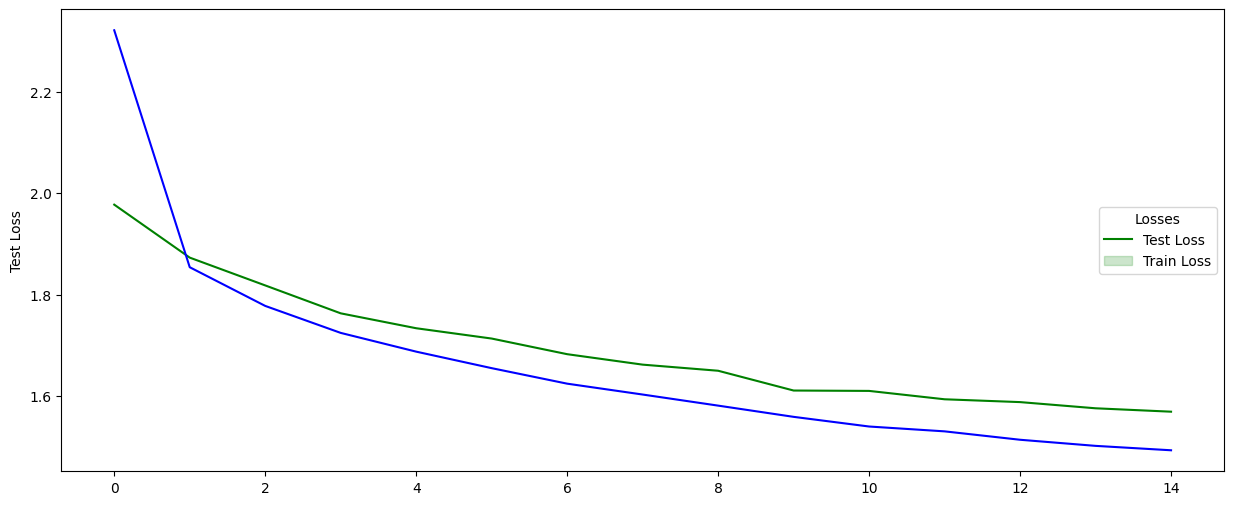

In [202]:
resnet18.metrics()

In [208]:
# alexnet_weights = models.AlexNet_Weights.DEFAULT
# alexnet = models.alexnet(weights=alexnet_weights).to(device)

# for param in alexnet.parameters():
#     param.requires_grad = False

# for param in alexnet.classifier.parameters():
#     param.requires_grad = True

# alexnet.classifier[-1] = nn.Linear(4096, 23).to(device)
# train_loss, test_loss, test_acc = train_model(alexnet, "alexnet")

In [209]:
alex_df = pd.concat([pd.DataFrame(train_loss), pd.DataFrame(test_loss), pd.DataFrame(test_acc)], axis=1)

In [210]:
# BusyBee.save("alexnet", alexnet, alex_df)

TypeError: BusyBee.save() missing 1 required positional argument: 'model_metrics'

In [164]:
def save(model_name, model):
    MODEL_PATH = Path("models") / model_name 
    
    if not os.path.exists(MODEL_PATH):
        MODEL_PATH.mkdir(parents=True, exist_ok=True)
    
    MODEL_SAVE_PATH = MODEL_PATH / f"{model_name}.pth"
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [216]:
MODEL_PATH = Path(r"C:\Users\Brand\project_env\models\alexnet")
model_name = "alexnet"
alex_df.to_csv(MODEL_PATH / f"{model_name}_metric.csv")

alexnet_0 = BusyBee("alexnet")

RuntimeError: Error(s) in loading state_dict for AlexNet:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([23, 4096]) from checkpoint, the shape in current model is torch.Size([1000, 4096]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([23]) from checkpoint, the shape in current model is torch.Size([1000]).